# 锚框是什么

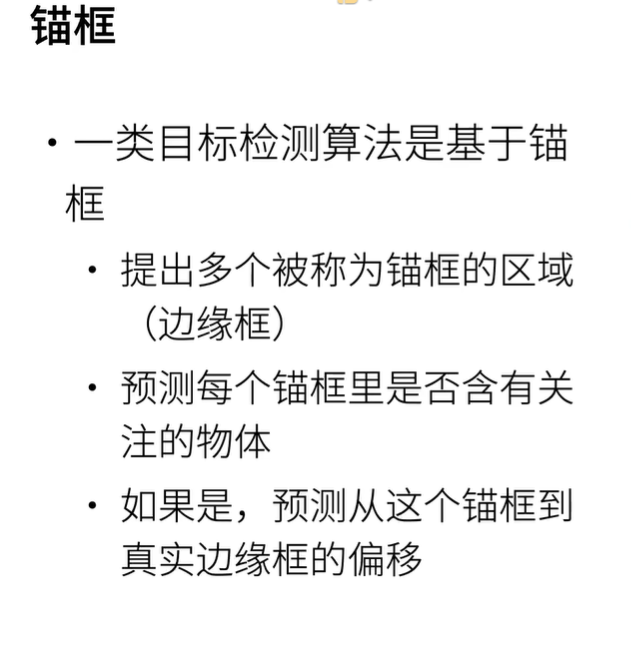

算法不直接预测4个具体位置 而是先圈出5个框

算法对图片画出5个框 预测这个锚框中是否有关注的物体

如果有则预测锚框到真实边缘框的距离

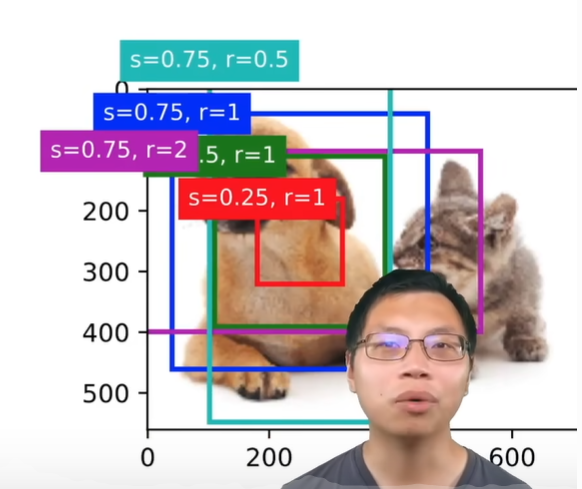

# 比较锚框和真实框的相似度 用IoU交并比的标准

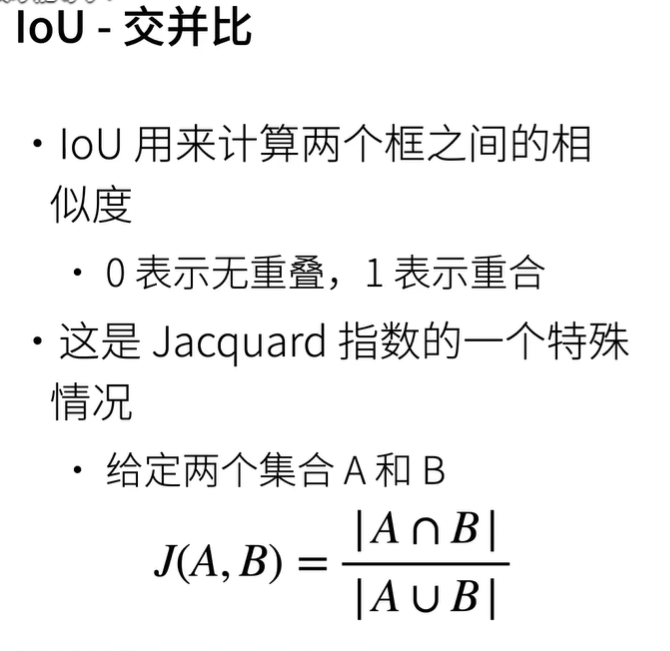

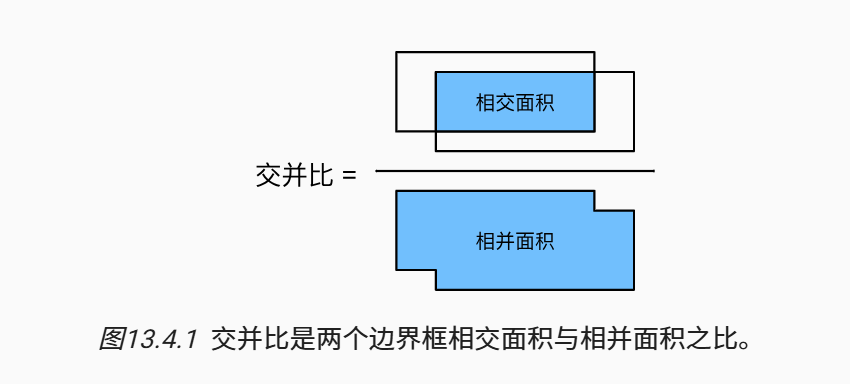

# 赋予锚框标号

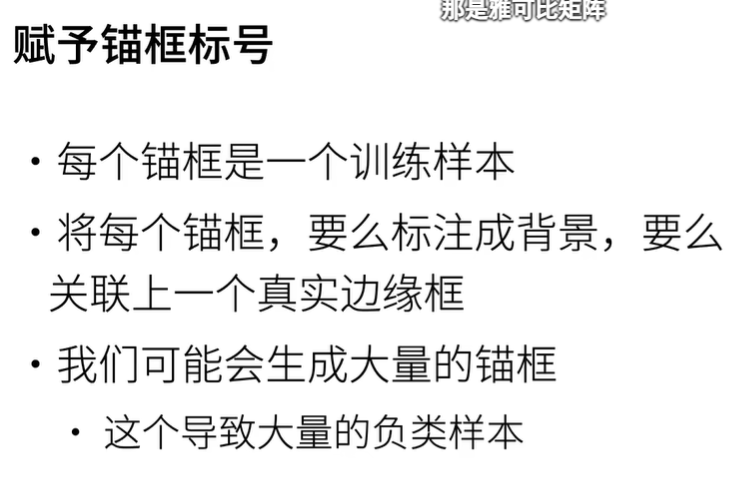

“赋予锚框标号”指的是将每个锚框与对应的目标物体匹配，并为每个锚框分配一个类别标签和相应的边界框回归目标。锚框（Anchor Box）是预定义的边界框，用于在图像的每个位置生成一组候选区域。这些候选区域可以包含目标物体，也可以不包含目标物体。

生成锚框：在图像的不同位置和尺度上生成一组锚框。每个锚框具有预定义的大小和宽高比。

匹配锚框与真实边界框：计算每个锚框与真实边界框之间的交并比（IoU，Intersection over Union）。选择与每个真实边界框 IoU 最高的锚框作为正锚框，并将其标记为该真实边界框的类别。其他锚框可能会被标记为背景（负锚框）。

分配类别标签和边界框回归目标：为每个锚框分配类别标签。如果锚框被标记为正锚框，则类别标签为对应目标物体的类别。对于正锚框，还会计算边界框回归目标，即锚框与真实边界框之间的偏移量。这些偏移量用于在训练过程中调整锚框，使其更准确地拟合目标物体。

赋予锚框标号是每次图片进来都要做的事情

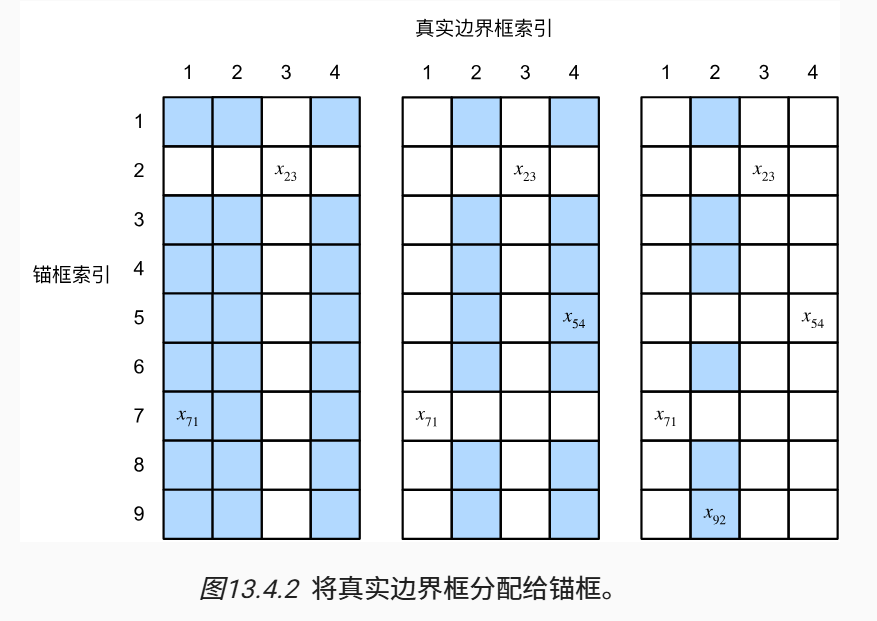

# 赋予标号的算法

使用非极大值抑制(NMS)输出
一种后处理技术，用于从多个候选边界框中筛选出最合适的边界框，去除重叠度较高的冗余框。NMS 通常用于目标检测任务，以减少重复的检测结果。

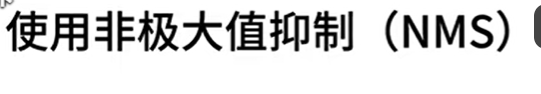

得到的框要么留下 要么被去掉

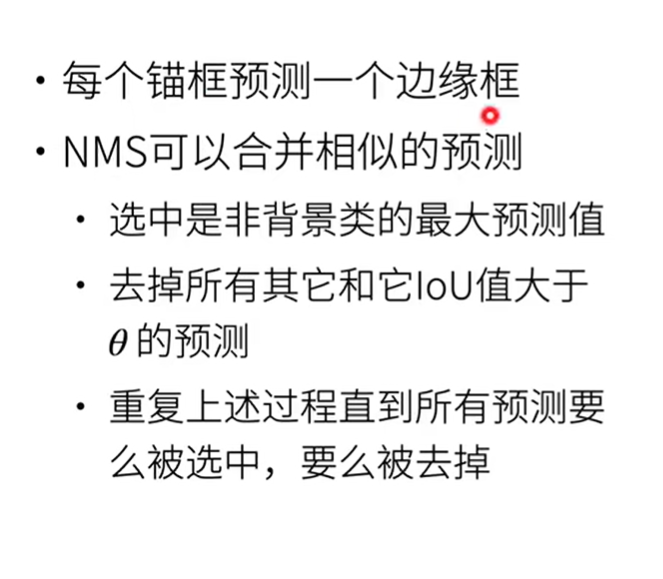

# 相当大一类的目标检测算法基于锚框来预测

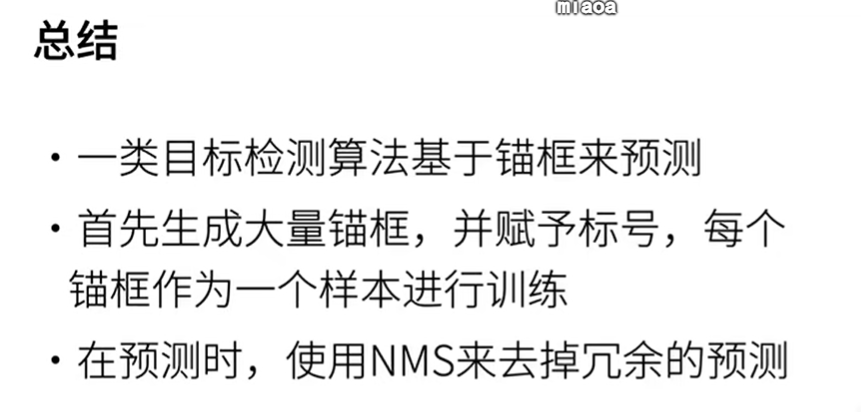

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度

In [3]:
# 一个锚框的生成
# 对于每一个像素为中心 生成不同个高度和宽度
#@save
# 一个锚框的生成
# 对于每一个像素为中心 生成不同个高度和宽度
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    
    # 获取输入图像的高度和宽度
    in_height, in_width = data.shape[-2:]
    device = data.device  # 获取输入数据的设备（CPU 或 GPU）
    num_sizes = len(sizes)  # 锚框的尺寸数量
    num_ratios = len(ratios)  # 锚框的宽高比数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)  # 每个像素的锚框数量
    size_tensor = torch.tensor(sizes, device=device)  # 将尺寸列表转为张量
    ratio_tensor = torch.tensor(ratios, device=device)  # 将宽高比列表转为张量

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5  # 锚框中心的偏移量
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h  # 计算锚框中心点的y坐标
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w  # 计算锚框中心点的x坐标
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')  # 生成锚框中心点的网格
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)  # 展平网格

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),  # 计算锚框的宽度
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),  # 计算锚框的高度
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2  # 计算锚框的四角坐标

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)  # 生成锚框中心的网格并重复
    output = out_grid + anchor_manipulations  # 计算每个锚框的四角坐标
    return output.unsqueeze(0)  # 增加一个维度以匹配输入数据的格式


In [6]:
# 读取图片
img = d2l.plt.imread('catdog.jpg')

# 获取图片的高度和宽度
h, w = img.shape[:2]

# 打印图片的高度和宽度
print(h, w)

# 创建一个随机的张量 X，形状为 (1, 3, h, w)
# 1 表示批次大小为 1
# 3 表示通道数为 3（RGB）
# h 和 w 表示图片的高度和宽度
X = torch.rand(size=(1, 3, h, w))

# 生成锚框
# sizes=[0.75, 0.5, 0.25] 表示锚框的三种尺度
# ratios=[1, 2, 0.5] 表示锚框的三种宽高比
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])

# 打印锚框的形状
Y.shape #生成200w的锚框 4为每个锚框的4个位置坐标

561 728


torch.Size([1, 2042040, 4])

In [8]:
# 访问以（250，250）为中心的第一个锚框

# 将生成的锚框 Y 重新形状为 (h, w, 5, 4)
# h 和 w 表示图片的高度和宽度
# 5 表示每个像素生成 5 个锚框
# 4 表示每个锚框有 4 个坐标值 (xmin, ymin, xmax, ymax)
boxes = Y.reshape(h, w, 5, 4)

# 提取位于图片中 (250, 250) 像素位置的第一个锚框的坐标值
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [13]:
# 画出以(250,250)为中心的所有锚框
# 定义显示所有边界框的函数
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    
    # 定义一个内部函数，用于将单个对象转换为列表
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    # 将 labels 和 colors 转换为列表，如果为空则使用默认值
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    # 遍历每个边界框
    for i, bbox in enumerate(bboxes):
        # 选择颜色
        color = colors[i % len(colors)]
        # 将边界框转换为矩形对象
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        # 在图像上添加矩形对象
        axes.add_patch(rect)
        # 如果有标签且标签数量大于当前索引，添加标签
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

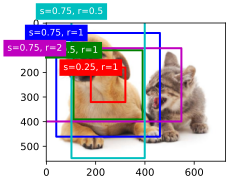

In [14]:
# 设置图像显示的尺寸
d2l.set_figsize()

# 缩放因子，用于将归一化的边界框坐标转换回原始图像尺寸
bbox_scale = torch.tensor((w, h, w, h))

# 读取并显示图像
fig = d2l.plt.imshow(img)

# 选取在位置 (250, 250) 上生成的所有锚框，并进行缩放
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])


In [15]:
#交并比（LoU）
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    
    # 定义一个匿名函数来计算每个框的面积
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    
    # 计算每个框的面积
    # boxes1, boxes2, areas1, areas2的形状：
    # boxes1: (boxes1的数量, 4)
    # boxes2: (boxes2的数量, 4)
    # areas1: (boxes1的数量,)
    # areas2: (boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    
    # 计算交集的左上角和右下角坐标
    # inter_upperlefts, inter_lowerrights, inters的形状：
    # (boxes1的数量, boxes2的数量, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    
    # 计算交集的面积和并集的面积
    # inter_areas和union_areas的形状：(boxes1的数量, boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    
    # 返回交并比
    return inter_areas / union_areas

In [16]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    
    # 获取锚框和真实边界框的数量
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    
    # 计算每个锚框和每个真实边界框之间的IoU（交并比）
    # jaccard的形状是 (num_anchors, num_gt_boxes)
    jaccard = box_iou(anchors, ground_truth)
    
    # 创建一个张量，记录每个锚框分配的真实边界框，初始值为-1（表示未分配）
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    
    # 根据阈值iou_threshold，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    
    # 初始化两个张量，用于标记已分配的锚框和真实边界框
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    # 迭代分配真实边界框，直到所有真实边界框都被分配
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        
        # 分配锚框给真实边界框
        anchors_bbox_map[anc_idx] = box_idx
        
        # 将已分配的锚框和真实边界框的IoU设置为-1，避免重复分配
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map

In [17]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [18]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

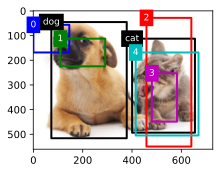

In [19]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [20]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [24]:
labels

(tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
           2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
          -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
           4.17e-06,  6.26e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

In [21]:
labels[2]

# 0框 -》背景
# 1框-》狗
# 2框=》猫
# 3框-》背景
# 4框-》猫

tensor([[0, 1, 2, 0, 2]])

In [22]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [23]:
labels[0] #偏移

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [25]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    
    # 将锚框从左上角和右下角的表示转换为中心和宽高的表示
    anc = d2l.box_corner_to_center(anchors)
    
    # 计算预测边界框的中心点坐标（x, y）
    # offset_preds[:, :2] 是预测的偏移量
    # anc[:, 2:] 是锚框的宽和高
    # 将偏移量缩放，之后加上锚框的中心点坐标
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    
    # 计算预测边界框的宽和高
    # offset_preds[:, 2:] 是预测的宽高偏移量
    # 通过指数函数将偏移量转化为实际的宽和高
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    
    # 将预测的中心点坐标和宽高组合成一个张量
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    
    # 将预测的中心和宽高表示转换为左上角和右下角的表示
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    
    return predicted_bbox

In [26]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [31]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [32]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

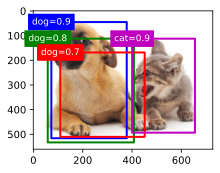

In [33]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [34]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

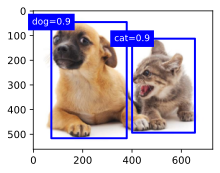

In [35]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

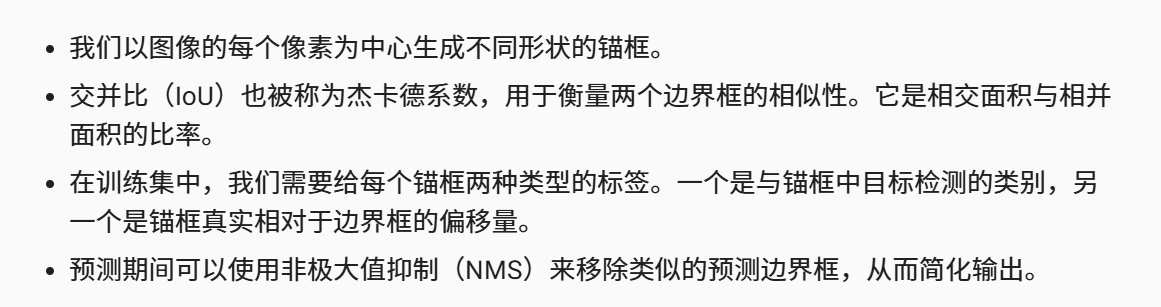